### Git

In [1]:
from pathlib import Path
from developerscope.analyzer import get_merge_commits_map

current_repo_path = Path().parent.resolve()
TARGET_REPO = "devQ_testData_PythonProject"
repo_path = current_repo_path.parent / TARGET_REPO


merge_commits_map, author_mapping = get_merge_commits_map(repo_path)



In [2]:
import git
git_repo = git.Repo(str(repo_path))

all_commits: list[git.Commit] = []
for author, commits in merge_commits_map.items():
    for commit in commits:
        merge_commit = git_repo.commit(commit)
        print(len(all_commits), merge_commit.message.split('\n')[0])
        all_commits.append(merge_commit)
        pass

0 Merge branch 'ci-cd-initial'
1 Merge branch 'dev-ci-cd-rollback-if-deploy-failed' into 'master'
2 Merge branch 'dev-run-without-venv' into 'master'
3 Merge branch 'master' into 'fix-20230629-failure'
4 Merge branch 'fix-20230629-failure' into 'master'
5 Merge branch 'feature/411326' into 'master'
6 Merge branch 'feature/412924' into 'master'
7 Merge branch 'feature/413010' into 'master'
8 Merge branch 'feature/413057' into 'master'
9 Merge branch 'feature/413234' into 'master'
10 Merge branch 'feature/413359' into 'master'
11 Merge branch 'feature/413433' into 'master'
12 Merge branch 'feature/ACL-8' into 'master'
13 Merge branch 'feature/414472' into 'master'
14 Merge branch 'feature/413063' into 'master'
15 Merge branch 'feature/413472' into 'master'
16 Merge branch 'feature/414883' into 'master'
17 Merge branch 'feature/434225' into 'master'
18 Merge branch 'feature/434432' into 'master'
19 Merge branch 'feature/434731' into 'master'
20 Merge branch 'feature/433257' into 'master'


In [ ]:
target_commit = all_commits[2]
target_commit.hexsha

### Author analysis

In [3]:
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [4]:
from typing import Final
from developerscope.haslted import halstead_effort

AUTHOR: Final[str] = next(iter(merge_commits_map))  
print(f"Scoring merge commits for “{AUTHOR}”")

# --- convert hashes → git.Commit objects ------------------------------------
author_commits = [git_repo.commit(h) for h in merge_commits_map[AUTHOR]]

scored = [
    (c, halstead_effort(c))          # returns a numeric effort value
    for c in author_commits
]

# --- take the 4 highest‑effort commits --------------------------------------
top4 = sorted(scored, key=lambda t: t[1], reverse=True)[:4]

for c, score in top4:
    print(f"{c.hexsha[:7]}  {score:,.0f}   {c.message.splitlines()[0]}")


Scoring merge commits for “iatskovskiivv”
2a2f65f  233,823   Merge branch 'feature/462794' into 'master'
10d52c8  233,823   Merge branch 'feature/462794' into 'master'
10d52c8  233,823   Merge branch 'feature/462794' into 'master'
45736eb  226,986   Merge branch 'feature/434225' into 'master'


In [6]:
import asyncio
from functools import partial

from developerscope.gpt import anylyze_commit

SEM = asyncio.Semaphore(3)  # limit to 4 concurrent analyse tasks

async def _bounded_analyse(commit: git.Commit):
    async with SEM:
        return await anylyze_commit(commit)

async def analyse_many(commits):
    tasks = [asyncio.create_task(_bounded_analyse(c)) for c, _ in commits]
    return await asyncio.gather(*tasks)


analyses = await analyse_many(top4)
analyses

get_file_contents {'files': ['accesslist/views.py', 'ownerlist/utils.py']}
accesslist/views.py
ownerlist/utils.py
get_file_contents {'files': ['accesslist/views.py', 'ownerlist/utils.py']}
accesslist/views.py
ownerlist/utils.py
get_file_contents {'files': ['accesslist/views.py', 'ownerlist/utils.py']}
accesslist/views.py
ownerlist/utils.py
get_file_contents {'files': ['ownerlist/utils.py']}
ownerlist/utils.py
get_file_contents {'files': ['ownerlist/utils.py']}
ownerlist/utils.py
get_file_contents {'files': ['ownerlist/utils.py']}
ownerlist/utils.py
get_file_contents {'files': ['ownerlist/utils.py', 'accesslist/views.py']}
accesslist/views.py
ownerlist/utils.py
get_file_contents {'files': ['ownerlist/utils.py']}
ownerlist/utils.py


['{"hiddenReasoning":"After reviewing the provided issues and the relevant code, only the following issues are of HIGH or CRITICAL severity: (1) The use of force push (`force=True`) in the `push()` method, which can overwrite remote history and cause data loss; (2) The risk of leaking sensitive information (such as gitlab tokens or usernames) via print statements and logs. These are both significant security and operational risks. The other issues are of lower severity and are omitted. The overall effort estimate remains \'Moderate\' as both issues are non-trivial and require careful remediation, but do not constitute a major architectural overhaul.","type":"Refactor","issues":[{"filePath":"ownerlist/utils.py","line":"1454-1478","issue":"The push() method now forcibly pushes with force=True, which can overwrite remote history. This could be dangerous if not intended, as it may cause data loss if multiple users are pushing to the same branch.","level":"HIGH"},{"filePath":"ownerlist/util

In [9]:
# Build a tidy list we can plot later
EFFORT_SCORE = {
    "Trivial": 1, "Minor": 2, "Moderate": 3, "Large": 4, "Major": 5
}

In [11]:
import json


plot_data = []
for (commit, _), analysis in zip(top4, analyses):
    analysis = json.loads(analysis)
    plot_data.append({
        "hash": commit.hexsha[:7],
        "effort": EFFORT_SCORE[analysis["effortEstimate"]],
        "issues": len(analysis["issues"]),
    })

plot_data

[{'hash': '2a2f65f', 'effort': 3, 'issues': 2},
 {'hash': '10d52c8', 'effort': 1, 'issues': 0},
 {'hash': '10d52c8', 'effort': 1, 'issues': 0},
 {'hash': '45736eb', 'effort': 2, 'issues': 1}]

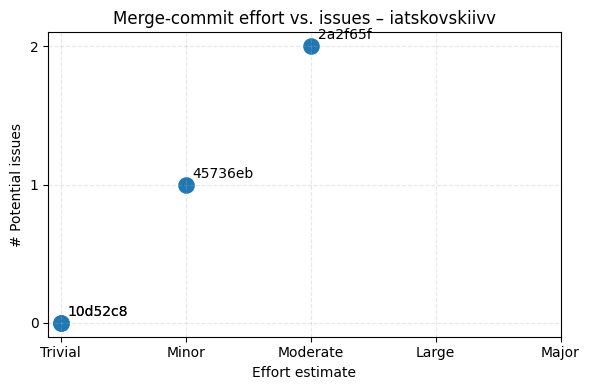

In [13]:
import matplotlib.pyplot as plt

xs = [d["effort"] for d in plot_data]
ys = [d["issues"] for d in plot_data]
labels = [d["hash"] for d in plot_data]

fig, ax = plt.subplots(figsize=(6,4))
scatter = ax.scatter(xs, ys, s=120, label=AUTHOR)

# Label each point with short commit hash
for x, y, lbl in zip(xs, ys, labels):
    ax.annotate(lbl, (x, y), xytext=(5, 5), textcoords="offset points")

ax.set_xticks(range(1, 6), ["Trivial", "Minor", "Moderate", "Large", "Major"])
ax.set_xlabel("Effort estimate")
ax.set_ylabel("# Potential issues")
ax.set_title(f"Merge-commit effort vs. issues – {AUTHOR}")

# Make y-axis integer only
ax.yaxis.get_major_locator().set_params(integer=True)

ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
await generate_html_report_for_author(AUTHOR, str(analyses))

✅ Report saved to: iatskovskiivv.html


In [30]:
with open('%s.json' % AUTHOR, 'w') as file:
    _analyses = [json.loads(x) for x in analyses]
    json.dump(_analyses, file, indent=4)

### Functions...




In [14]:

SYSTEM_PROMPT_REPORT_GENERATOR = """
You are a helpful assistant that generates clean, minimal, and readable HTML reports for software engineering analysis.

You receive a raw Python-style data string representing commit analyses for one or more developers. Each entry includes:
- commit hash (short)
- effort estimate (e.g., "Trivial", "Minor", "Moderate", "Large", "Major")
- issue count (integer)
- author name or ID

Your task is to convert this into a clean and compact HTML page with:
- a table listing the analyzed commits
- one section per developer (if multiple)
- short summary statistics (e.g., average issues, most common effort)
- simple CSS styling for readability (use embedded `<style>`)
- highlight commits with 3+ issues or "Major" effort visually (bold or colored row)

Use semantic HTML (`<section>`, `<table>`, `<thead>`, `<tbody>`, etc.). Keep it visually appealing but minimal — no JavaScript, no external fonts.

Assume the user will paste the full raw data in the user message. Do not explain the result — just return the HTML content.

example:
```html
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Commit Analysis Report</title>
  <style>
    body {
      font-family: system-ui, sans-serif;
      background: #fafbfc;
      margin: 0;
      padding: 2rem;
      color: #222;
    }
    h1, h2 {
      font-weight: 600;
      margin-top: 1.5em;
      margin-bottom: 0.5em;
    }
    section {
      margin-bottom: 2.5em;
      border-radius: 6px;
      background: #fff;
      box-shadow: 0 2px 8px rgba(0,0,0,0.04);
      padding: 1.5em 1.5em 1em 1.5em;
    }
    table {
      border-collapse: collapse;
      width: 100%;
      font-size: 1em;
      margin-bottom: 1em;
    }
    th, td {
      padding: 0.6em 0.5em;
      border-bottom: 1px solid #eaeaea;
      text-align: left;
    }
    th {
      background: #f3f5f7;
      color: #333;
      font-weight: 600;
    }
    tr.highlight {
      background: #fff4e5;
      font-weight: 600;
      color: #a64d00;
    }
    .summary {
      font-size: 0.98em;
      background: #f6f9fa;
      border-radius: 4px;
      padding: 0.8em 1em;
      margin-bottom: 1.2em;
      display: inline-block;
    }
    .effort-Major,
    .effort-Major td
    { color: #d32f2f !important; }
    .effort-Moderate,
    .effort-Moderate td
    { color: #e78121 !important; }
    .effort-Minor,
    .effort-Minor td
    { color: #22863a !important; }
    .effort-Trivial,
    .effort-Trivial td
    { color: #546e7a !important; }
    @media (max-width: 700px) {
      body { padding: 0.5rem; }
      section { padding: 1em; }
      th, td { font-size: 0.93em; }
      .summary { font-size: 0.92em; }
    }
  </style>
</head>
<body>
  <h1>Commit Analysis Report</h1>

  <section>
    <h2>Summary</h2>
    <div class="summary">
      <strong>Total Commits:</strong> 4 &nbsp;·&nbsp;
      <strong>Average Issues per Commit:</strong> 0.75 &nbsp;·&nbsp;
      <strong>Most Common Effort:</strong> Trivial
    </div>
  </section>

  <section>
    <h2>Commits</h2>
    <table>
      <thead>
        <tr>
          <th>#</th>
          <th>Commit Type</th>
          <th>Effort Estimate</th>
          <th>Issue Count</th>
          <th>Key Issue(s)</th>
        </tr>
      </thead>
      <tbody>
        <tr class="effort-Moderate">
          <td>1</td>
          <td>Refactor</td>
          <td>Moderate</td>
          <td>2</td>
          <td>
            <ul style="margin:0 0 0 1.2em;padding:0 0 0 0.2em;">
              <li>Dangerous use of <code>force=True</code> in <code>push()</code>, can overwrite history</li>
              <li>Risk of leaking sensitive info (tokens/usernames) via logs/prints</li>
            </ul>
          </td>
        </tr>
        <tr class="effort-Trivial">
          <td>2</td>
          <td>Refactor</td>
          <td>Trivial</td>
          <td>0</td>
          <td>
            <em>No high/critical issues</em>
          </td>
        </tr>
        <tr class="effort-Trivial">
          <td>3</td>
          <td>Refactor</td>
          <td>Trivial</td>
          <td>0</td>
          <td>
            <em>No high/critical issues</em>
          </td>
        </tr>
        <tr class="effort-Minor">
          <td>4</td>
          <td>Bug‑fix</td>
          <td>Minor</td>
          <td>1</td>
          <td>
            <ul style="margin:0 0 0 1.2em;padding:0 0 0 0.2em;">
              <li>Credentials in repo URL could leak via logs/process lists if not sanitized</li>
            </ul>
          </td>
        </tr>
      </tbody>
    </table>
  </section>
</body>
</html>
```
"""


In [22]:
from developerscope.gpt import client
async def generate_html_report_for_author(
    author: str,
    data: str,
):
    input_messages = [
        {"role": "system", "content": SYSTEM_PROMPT_REPORT_GENERATOR},
        {"role": "user", "content": data},
    ]

    response = await client.responses.create(
        model="gpt-4.1",
        input=input_messages,
    )

    html_output = response.output[0].content[0].text.strip().replace('```html','').replace('```')

    output_path = Path(f"{author}.html")
    output_path.write_text(html_output, encoding="utf-8")

    print(f"✅ Report saved to: {output_path}")


In [ ]:
for result in analyses:
    print()